# Running models individually for each house

In [16]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
import time
import xgboost as xgb

In [17]:
data = pd.read_excel("../datasets/Dataset.xlsx", sheet_name=['Total Consumers'])
df = data['Total Consumers']
number_of_houses = len(df.columns)
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,0.814643,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2.584,2.371797,1.544607,0.778310,1.962012,2.733737,0.192929,0.558967,0.358525,0.660712,...,0.917793,0.165311,0.179747,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863
2,3.071,2.415961,1.319880,0.665072,1.676555,2.784640,0.382869,1.109272,0.377198,1.311186,...,0.934883,0.328060,0.356708,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682
3,2.694,2.302538,1.319880,0.665072,1.676555,2.653908,0.442052,1.280743,0.377198,1.513868,...,0.890992,0.378772,0.411848,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623
4,2.569,2.363063,0.913154,0.460128,1.159919,2.723669,0.192242,0.556976,0.668500,0.658358,...,0.914413,0.164722,0.179106,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,1.664,2.244719,1.455982,0.733653,1.849437,2.587266,0.205654,0.595835,0.171793,0.704291,...,0.868619,0.176214,0.191602,0.153109,0.803007,0.893832,0.189444,0.237645,0.957128,0.753222
35132,1.659,2.136340,1.201186,0.605264,1.525786,2.462348,0.201219,0.582985,0.067223,0.689101,...,0.826680,0.172414,0.187470,0.059912,0.764237,0.850676,0.185359,0.232519,0.910916,0.716855
35133,1.664,2.192805,1.201186,0.605264,1.525786,2.527430,0.228585,0.662271,0.067223,0.782819,...,0.848530,0.195862,0.212966,0.059912,0.784436,0.873160,0.210568,0.264142,0.934992,0.735802
35134,1.697,1.446083,0.259545,0.130782,0.329682,1.666757,0.189302,0.548459,0.070958,0.648292,...,0.559578,0.162203,0.176368,0.063241,0.517310,0.575820,0.174381,0.218749,0.616596,0.485237


## Auxiliary functions

In [18]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
    
def performance_metrics(preds: np.array, actuals: np.array):

    # calculate performance metrics
    
    mse = mean_squared_error(actuals, preds)
    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mse)
    wape = np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals)) * 100
    #mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
    #mape = mae / actuals.mean()  
    r2 = r2_score(actuals, preds)

    # print performance metrics
    print('MSE: %.4f' % mse)
    #print('RMSE: %.4f' % rmse)
    #print('MAE: %.4f' % mae)
    #print('WMAPE: %.4f' % wmape)
    print('WAPE: %.3f' % wape)
    print('R2: %.4f' % r2)
    return mse, wape, r2

def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train.values.ravel())
    preds = model.predict(X_test)
    #scores = cross_validate(estimator, X_train, y_train.values.ravel(), scoring=['r2','neg_mean_squared_error'])
    return model, preds

In [31]:
def total_averaged_metrics(metrics_list):
    mse, wape, r2 = 0,0,0,
    for house in metrics_list:
        mse += sum(i for i, j, k in house)
        wape += sum(j for i, j, k in house)
        r2 += sum(k for i, j, k in house)
    t_mse = np.round(mse/len(metrics_list),3)
    t_wape = np.round(wape/len(metrics_list),3)
    t_r2 = np.round(r2/len(metrics_list),3)
    print("Total Averaged MSE: {}".format(t_mse))
    print("Total Averaged WAPE: {}".format(t_wape))
    print("Total Averaged R2: {}".format(t_r2))
    return t_mse, t_wape, t_r2


def last_energy_points(df, number_timesteps):
    X = pd.DataFrame()
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df.shift(i)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y = pd.DataFrame(df[number_timesteps:])
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    return X, y

def build_predict_show(df, number_timesteps, estimator, normalize=False, train_size=0.8, start_timestep=1 ):
    full_start = time.time()
    metrics_list = []
    for i in range(start_timestep,(number_timesteps + 1)):
        start = time.time()
        print("\nNumber of features ", i)
        X, y = last_energy_points(df, i)

        X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=train_size)
        
        if(normalize):
            scaler = MinMaxScaler().fit(X_train)
            X_train_norm = scaler.transform(X_train)
            X_test_norm = scaler.transform(X_test)
        
        model, preds = build_model(estimator, X_train, y_train, X_test)
        mse, wape, r2 = performance_metrics(preds, y_test.values.reshape(-1))
        metrics_list.append((mse, wape,r2))
        print("\nElapsed time: %.3f seconds" % (time.time() - start))
    print("\nFull Elapsed time: %.3f seconds" % (time.time() - full_start))
    return model, preds, metrics_list

def split_train_test_timeseries(X, y, train_size: int):
    n_train_samples = int(len(X) * train_size)
    X_train = X[:n_train_samples]
    X_test = X[n_train_samples:]
    y_train = y[:n_train_samples]
    y_test = y[n_train_samples:]
    return X_train, X_test, y_train, y_test

def show_graphic_per_timestep(metrics_list, number_timesteps, start_timestep=1):
    mse_list = []
    wape_list = []
    r2_list = []

    for i in range(0,len(metrics_list)):
        mse_list.append(metrics_list[i][0][0])
        wape_list.append(metrics_list[i][0][1])
        r2_list.append(metrics_list[i][0][2])
        
    plt.plot(range(0,number_of_houses), mse_list)
    plt.title('MSE per house')
    plt.xlabel('Number of houses')
    plt.ylabel('MSE')
    plt.show()
    
    plt.plot(range(0,number_of_houses), wape_list)
    plt.title('WAPE per house')
    plt.xlabel('Number of houses')
    plt.ylabel('WAPE')
    plt.show()
    
    plt.plot(range(0,number_of_houses), r2_list)
    plt.title('R2 per house')
    plt.xlabel('Number of houses')
    plt.ylabel('R2')
    plt.show()
    

### Normalize data

In [ ]:
values = df.values
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(df_scaled)
df_scaled

## Preprocessing

In [24]:
X,y = last_energy_points(df[0], 97)
print(X.shape, y.shape)
X

(35039, 97) (35039, 1)


,Energy_15,Energy_30,Energy_45,Energy_60,Energy_75,Energy_90,Energy_105,Energy_120,Energy_135,Energy_150,...,Energy_1320,Energy_1335,Energy_1350,Energy_1365,Energy_1380,Energy_1395,Energy_1410,Energy_1425,Energy_1440,Energy_1455
0,3.054,2.528,2.917,2.483,2.575,3.039,3.288,2.629,2.599,2.344,...,3.223,2.994,2.922,2.558,3.174,2.569,2.694,3.071,2.584,2.964
1,2.677,3.054,2.528,2.917,2.483,2.575,3.039,3.288,2.629,2.599,...,2.553,3.223,2.994,2.922,2.558,3.174,2.569,2.694,3.071,2.584
2,3.522,2.677,3.054,2.528,2.917,2.483,2.575,3.039,3.288,2.629,...,3.047,2.553,3.223,2.994,2.922,2.558,3.174,2.569,2.694,3.071
3,2.729,3.522,2.677,3.054,2.528,2.917,2.483,2.575,3.039,3.288,...,3.310,3.047,2.553,3.223,2.994,2.922,2.558,3.174,2.569,2.694
4,2.368,2.729,3.522,2.677,3.054,2.528,2.917,2.483,2.575,3.039,...,2.514,3.310,3.047,2.553,3.223,2.994,2.922,2.558,3.174,2.569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35034,1.670,1.686,1.664,1.651,1.655,1.662,1.662,1.659,1.668,1.675,...,1.664,1.671,1.673,1.667,1.673,1.697,1.664,1.659,1.664,1.670
35035,1.664,1.670,1.686,1.664,1.651,1.655,1.662,1.662,1.659,1.668,...,1.669,1.664,1.671,1.673,1.667,1.673,1.697,1.664,1.659,1.664
35036,1.659,1.664,1.670,1.686,1.664,1.651,1.655,1.662,1.662,1.659,...,1.664,1.669,1.664,1.671,1.673,1.667,1.673,1.697,1.664,1.659
35037,1.664,1.659,1.664,1.670,1.686,1.664,1.651,1.655,1.662,1.662,...,1.663,1.664,1.669,1.664,1.671,1.673,1.667,1.673,1.697,1.664


## Test model

In [25]:
start_timestep = 97
number_timesteps = 97

## XGBoost

In [26]:
model_xgb, preds_xgb, metrics_list_xgb = [],[],[]
start_t = time.time()
for house in range(0,number_of_houses):
    print("\n House {}".format(house))
    mo_xgb, p_xgb, ml_xgb = build_predict_show(df[house], number_timesteps, xgb.XGBRegressor(seed=42), start_timestep=start_timestep)
    model_xgb.append(mo_xgb)
    preds_xgb.append(p_xgb)
    metrics_list_xgb.append(ml_xgb)
print("\nXGBoost Elapsed time: %.3f seconds" % (time.time() - start_t))


 House 0

Number of features  97
MSE: 0.1705
WAPE: 7.251
R2: 0.9874

Elapsed time: 0.935 seconds

Full Elapsed time: 0.935 seconds

 House 1

Number of features  97
MSE: 0.2550
WAPE: 29.096
R2: 0.7428

Elapsed time: 1.226 seconds

Full Elapsed time: 1.226 seconds

 House 2

Number of features  97
MSE: 0.0632
WAPE: 15.744
R2: 0.9434

Elapsed time: 0.661 seconds

Full Elapsed time: 0.661 seconds

 House 3

Number of features  97
MSE: 0.0125
WAPE: 15.260
R2: 0.9521

Elapsed time: 0.659 seconds

Full Elapsed time: 0.659 seconds

 House 4

Number of features  97
MSE: 0.0977
WAPE: 15.546
R2: 0.9437

Elapsed time: 0.660 seconds

Full Elapsed time: 0.660 seconds

 House 5

Number of features  97
MSE: 0.3313
WAPE: 28.742
R2: 0.7474

Elapsed time: 1.237 seconds

Full Elapsed time: 1.237 seconds

 House 6

Number of features  97
MSE: 0.0661
WAPE: 36.592
R2: 0.6136

Elapsed time: 1.562 seconds

Full Elapsed time: 1.562 seconds

 House 7

Number of features  97
MSE: 0.5349
WAPE: 36.313
R2: 0.6139


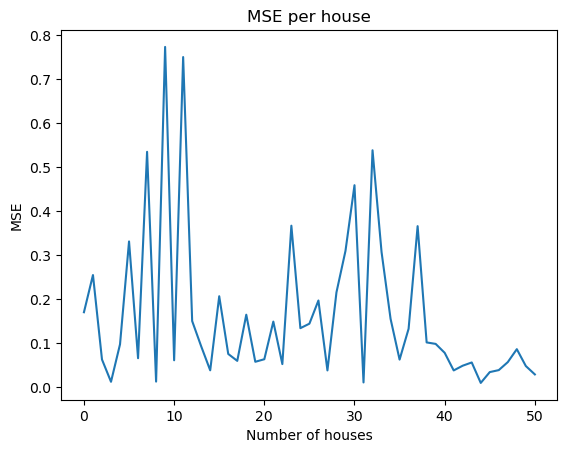

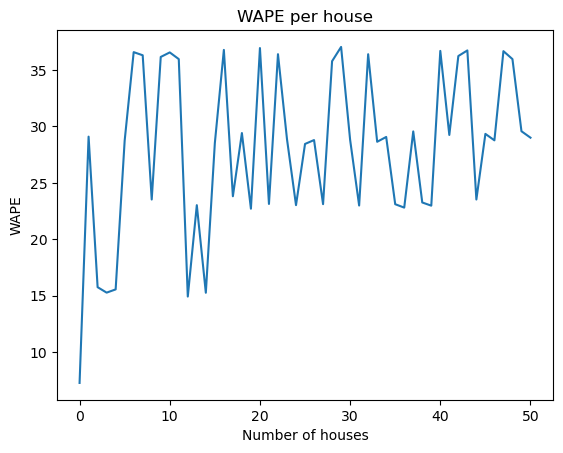

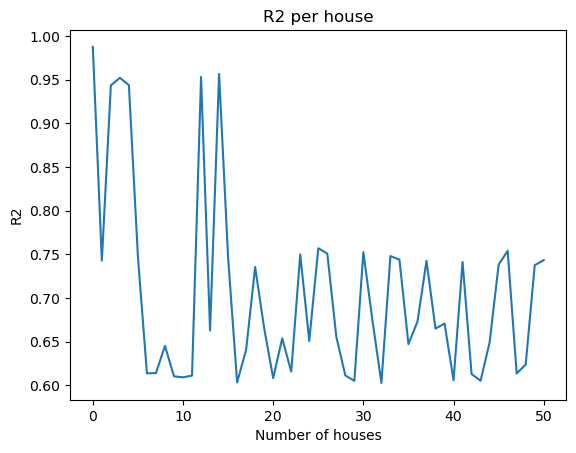

In [27]:
show_graphic_per_timestep(metrics_list_xgb, number_timesteps, start_timestep=start_timestep)

### Total average

In [32]:
t_mse,t_wape, t_r2 = total_averaged_metrics(metrics_list_xgb)

Total Averaged MSE: 0.165
Total Averaged WAPE: 28.082
Total Averaged R2: 0.706


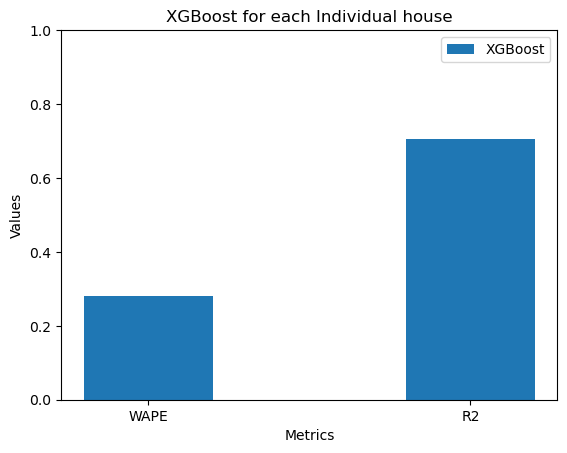

In [35]:
X_names = ("WAPE", "R2")
X_axis = np.arange(len(X_names))
plt.bar(X_axis, (t_wape / 100, t_r2), 0.4, label = 'XGBoost')
plt.ylim(0,1)
plt.xticks(X_axis, X_names)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("XGBoost for each Individual house")
plt.legend()
plt.show()